<a href="https://colab.research.google.com/github/itaborai83/ecd221-ML-trabalho/blob/main/ML_7_Projeto_completo_de_Classifica%C3%A7%C3%A3o_Bin%C3%A1ria_Telco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning - Prof. Tatiana Escovedo
# Projeto completo de Classificação Binária


## 1. Definição do Problema

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

**Informações sobre os atributos:**

Adicionar

In [100]:
# função de correlação que funciona com variáveis categóricas e numéricas
! pip install phik category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # transformador de colunas, usado para tratamento das variáveis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report

from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

# redução de dimensionalidade
from sklearn.decomposition import PCA

# para baixar os modelos já treinados
import urllib.request

from pprint import pprint, pformat

import pickle # para persistência de modelos

In [102]:
# setup ambiente

# supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

# configura cores do Seaborn
sns.set()

In [103]:
# constantes

DATA_URL                    = f"https://raw.githubusercontent.com/itaborai83/ecd221-ML-trabalho/main/telco-churn.csv"
FIELD_SEPARATOR             = ","
IMPORT_COLUMN_NAMES         = [
    "customer_id"
,   "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "tenure"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
COLUMN_NAMES = [
    "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "tenure"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
TARGET_VARIABLE = "churn"
BOOLEAN_FEATURES = [
    "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "paperless_billing"
]
CATEGORICAL_FEATURES = [
    "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "payment_method"
]
NUMERICAL_FEATURES                  = ["tenure", "monthly_charges", "total_charges"]
NUMERICAL_FEATURES_AFTER_FEAT_ENG   = ["tenure", "monthly_charges", "total_charges", "client_factor", "internet_factor", "financial_factor"]
BOOLEAN_MAP                         = {"No": 0, "Yes": 1}
TEST_PCT_SIZE                       = 0.3 # 30% do conjunto de dados
RANDOM_STATE                        = 42
SCORING_METRIC                      = "roc_auc"
K_FOLDS                             = 6
RETURN_TRAIN_SCORE                  = False
OUTPUT_TRAINING_FILE_TMPLT          = "RandomizedSearchCV_{algo}.xlsx"
QUICK_RUN                           = False
DOWNLOAD_MODELS_URL                 = "https://github.com/itaborai83/ecd221-ML-trabalho/raw/main/"
MODEL_SETTINGS                      = {
     "logreg"           : { "model_file": "logreg.pkl", "train": False, "download": True }
,    "knn"              : { "model_file": "knn.pkl",    "train": False, "download": True }
,    "nb"               : { "model_file": "nb.pkl",     "train": False, "download": True }
,    "dt"               : { "model_file": "dt.pkl",     "train": False, "download": True }
,    "svm"              : { "model_file": "svm.pkl",    "train": False, "download": True }
,    "ada"              : { "model_file": "ada.pkl",    "train": False, "download": True }
,    "gb"               : { "model_file": "gb.pkl",     "train": False, "download": True }
,    "rf"               : { "model_file": "rf.pkl",     "train": False, "download": True }    
}

## 2. Carga de Dados

Iremos usar o pacote Pandas ( Python Data Analysis Library) para carregar de um arquivo .csv sem cabeçalho disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [104]:
# Carrega arquivo csv usando Pandas usando uma URL
churn_df = pd.read_csv(
    DATA_URL
,   names     = IMPORT_COLUMN_NAMES
,   skiprows  = 1
,   delimiter = ','
)

# transforma a variável target em uma variável numérica
churn_df["churn"] = churn_df["churn"].map(BOOLEAN_MAP)

# excluindo a variável customer_id
del churn_df["customer_id"]

for algo in MODEL_SETTINGS:
  model_setting = MODEL_SETTINGS[algo]
  download      = model_setting["download"]
  model_file    = model_setting["model_file"]
  if download:
    url = DOWNLOAD_MODELS_URL + model_file
    urllib.request.urlretrieve(url, model_file)

In [105]:
churn_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [106]:
# Mostra as dimensões do dataset
print(churn_df.shape)

(7043, 20)


In [107]:
# Mostra as informações do dataset
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

o dataset possui predominantesmente dados categóricos, representados acima como objetos com tipo de dados **object**

In [108]:
# Mostra as 10 primeiras linhas do dataset
churn_df.head(10)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


A variável **monthly_charges** aparenta ser numérica.


In [109]:
# a conversão do tipo da coluna abaixo falha com o erro "ValueError: could not convert string to float"
# churn_df["total_charges"] = churn_df["total_charges"].astype(float)

# tenta identificar valores problemáticos
def convertible_to_float(value):
  try:
    f = float(value)
    return True
  except:
    return False
is_float = churn_df["total_charges"].map(convertible_to_float)
churn_df["total_charges_is_float"] = is_float
display(churn_df[ churn_df["total_charges_is_float"] == False ][ "total_charges" ].map(repr))


488     ' '
753     ' '
936     ' '
1082    ' '
1340    ' '
3331    ' '
3826    ' '
4380    ' '
5218    ' '
6670    ' '
6754    ' '
Name: total_charges, dtype: object

O dataframe possui 11 registros com valor ' ' na coluna total_charges. Os valores serã convertidos para zero e posteriormente analisados


In [110]:
def convert_total_charges(value):
    return 0.0 if value == ' ' else value

churn_df["total_charges"] = churn_df["total_charges"].map(convert_total_charges).astype(float)
del churn_df["total_charges_is_float"]

In [111]:
# Mostra as 10 últimas linhas do dataset
churn_df.tail(10)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
7033,Male,0,No,No,38,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,0
7034,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,1
7035,Male,0,No,No,19,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,0
7036,Female,0,No,No,12,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,743.30,0
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1
7042,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,0


Diferente das outras variáveis categóricas, a variável **senior_citizem** está utilizando 0's e 1's para representar verdadeiro e falso. Iremos converter estes dados momentamenteamente por questões de consistência

In [112]:
churn_df["senior_citizen"] = churn_df["senior_citizen"].map({1: "Yes", 0: "No"})

É sempre importante verificar o tipo do atributos do dataset, pois pode ser necessário realizar conversões. Já fizemos anteriormente com o comando info, mas vamos ver uma outra forma de verificar a natureza de cada atributo e então exibir um resumo estatístico do dataset.

In [113]:
# Verifica o tipo de dataset de cada atributo
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [114]:
# Faz um resumo estatístico das variáveis numéricas do dataset (média, desvio padrão, mínimo, máximo e os quartis)
churn_df.describe()

,tenure,monthly_charges,total_charges,churn
count,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73,0.27
std,24.56,30.09,2266.79,0.44
min,0.00,18.25,0.00,0.00
25%,9.00,35.50,398.55,0.00
50%,29.00,70.35,1394.55,0.00
75%,55.00,89.85,3786.60,1.00
max,72.00,118.75,8684.80,1.00


a variável **total_charges** é numericamente muito próxima das variáveis **tenure** e **monthly_charges** multiplicadas e por isso será removida

In [115]:
churn_df["tenure*monthly"] = churn_df["tenure"] * churn_df["monthly_charges"]
churn_df["churn"] = churn_df.pop("churn")
display(churn_df.describe())
del churn_df["tenure*monthly"]

,tenure,monthly_charges,total_charges,tenure*monthly,churn
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73,2279.58,0.27
std,24.56,30.09,2266.79,2264.73,0.44
min,0.00,18.25,0.00,0.00,0.00
25%,9.00,35.50,398.55,394.00,0.00
50%,29.00,70.35,1394.55,1393.60,0.00
75%,55.00,89.85,3786.60,3786.10,1.00
max,72.00,118.75,8684.80,8550.00,1.00


O dataset não possui valores faltantes ou valores anormalmente altos ou baixos em suas variaveis numéricas

Vamos agora verificar se o dataset tem as classes balanceadas para que possamos tratar o desbalanceamento posteriormente, se necessário. Veremos que as classes 0 (permaneceu cliente) e 1 (não permaneceu cliente) estão desbalanceadas. Vamos guardar esta informação, pois possivelmente precisaremos realizar algum tipo de tratamento nas próximas etapas.

In [116]:
# distribuição das classes
pd.crosstab(churn_df[TARGET_VARIABLE], churn_df[TARGET_VARIABLE], normalize=True)

churn,0,1
churn,,
0,0.73,0.00
1,0.00,0.27


Não está claro se o balanceamento de classes e a distribuição das variáveis do dataset correspondem à dados observados na vida real ou se algum tipo de curadoria ou rebalanceamento foi realizado (dado que a rotatividade de clientes na ordem de 27% parece ser um percentual muito elevado)

In [117]:
pd.crosstab(churn_df["gender"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
gender,,,
Female,0.36,0.13,0.50
Male,0.37,0.13,0.50
All,0.73,0.27,1.00


A variável **gender** está balanceada no dataset e também balanceado quando comparada à variável target. Não está claro se essa variável é realmente útil.

In [118]:
pd.crosstab(churn_df["senior_citizen"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
senior_citizen,,,
No,0.64,0.20,0.84
Yes,0.09,0.07,0.16
All,0.73,0.27,1.00


A variável categórica **senior_citizen** parece influenciar a rotatividade de clientes.

Se por um lado 84% dos clientes não estão na terceira idade, aproximadamente 75% (20%/27%) dos ex-clientes pertencem à esta categoria.

Por sua vez, os clientes pertencentes à terceira idade correspondem a apenas 16% dos clientes, mas desses 16%, 43% deixaram de ser clientes.

Em outras palavras. Em termos absolutos, um ex-cliente tem maior probabilidade de não pertencer a terceira idade. Em contra-partida, dado que um cliente pertence à terceira idade, ele tem maior probabilidade de se tornar um ex-cliente.




In [119]:
pd.crosstab(churn_df["partner"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
partner,,,
No,0.35,0.17,0.52
Yes,0.39,0.09,0.48
All,0.73,0.27,1.00


A variável **partner**, que indica se um cliente possui ou não algum tipo de parceiro/cônjuge parece estar bem distribuída no conjunto de dados com aproximadamente metade dos clientes tendo algum parceiro e a outra metade não.

Entretanto, podemos que observar que a retenção dos clientes tende a ser pior entre os clientes que não possuem algum tipo de parceiro, pois aproximadamente 2/3 dos ex-clientes enquadram-se nessa situação

In [120]:
pd.crosstab(churn_df["dependents"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
dependents,,,
No,0.48,0.22,0.70
Yes,0.25,0.05,0.30
All,0.73,0.27,1.00


A variável **dependents**, que indica se um cliente possui ou não algum tipo de dependente parece ser um forte indicador sobre a rotatividade dos clientes pois mais de 81% (22%/27%) dos ex-clientes não possuem dependentes.

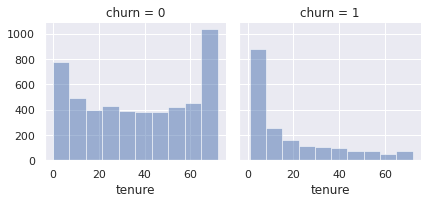

In [121]:
g = sns.FacetGrid(churn_df, col="churn", size=3)
g.map_dataframe(plt.hist, x="tenure", alpha=0.5)
g.add_legend();

A variável **tenure**, que representa o número de meses em que um cliente possui algum tipo de relacionamento comercial com a empresa, parece indicar que a empresa oferece planos/contratos de duração máxima de 72 meses. 

Analisando os clientes que permaneceram com a empresa, podemos obseravar uma distribuição em forma de U, onde um número sigificativo de clientes possuem poucos meses de relacionamento e um número ainda maior parece estar se aproximando do teto de 72 meses.

Por sua vez, a análise dos futuros ex-clientes indicam que a maioria parece cancelar seus serviços nos primeiros meses de relacionamento com a empresa e, passado o tempo, fidelizam-se.

Estas distribuições parecem indicar a necessidade de que medidas de fidelização sejam tomadas nos críticos primeiros meses.

In [122]:
pd.crosstab(churn_df["phone_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
phone_service,,,
No,0.07,0.02,0.10
Yes,0.66,0.24,0.90
All,0.73,0.27,1.00


A variável **phone_service** está extremamente desbalanceada e o fato de um usuário não possuir nenhum tipo de serviço telefônico contratado parece não ser expressivo em termos absolutos ou relativos

In [123]:
pd.crosstab(churn_df["multiple_lines"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
multiple_lines,,,
No,0.36,0.12,0.48
No phone service,0.07,0.02,0.10
Yes,0.30,0.12,0.42
All,0.73,0.27,1.00


A variável **multiple_lines** parece não informações significativas para determinar a rotatividade dos clientes

In [124]:
pd.crosstab(churn_df["internet_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
internet_service,,,
DSL,0.28,0.07,0.34
Fiber optic,0.26,0.18,0.44
No,0.20,0.02,0.22
All,0.73,0.27,1.00


A variável **internet_service** usada para identificar qual o tipo de fornecimento de internet o usuário possui (ou não) indica que quase 2/3 entre todos os ex-clientes parecem ter contratado internet por fibra ótica.

Isso parece indicar a existência de problemas na qualidade do fornecimento do serviço ou na precificação do mesmo.

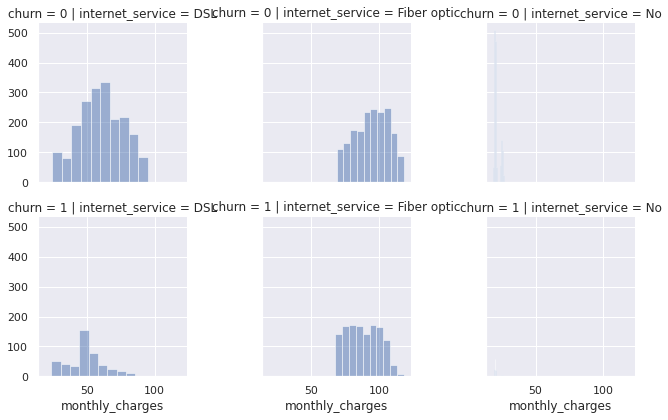

In [125]:
g = sns.FacetGrid(churn_df, col="internet_service", row="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

O serviço de fibra ótica, conforme esperado, parece contribuir com o aumento dos custos mensais dos clientes e consequentemente afetando negativamente na retenção dos clientes que contrataram esse serviço.

In [126]:
pd.crosstab(churn_df["online_security"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
online_security,,,
No,0.29,0.21,0.50
No internet service,0.20,0.02,0.22
Yes,0.24,0.04,0.29
All,0.73,0.27,1.00


In [127]:
pd.crosstab(churn_df["online_backup"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
online_backup,,,
No,0.26,0.18,0.44
No internet service,0.20,0.02,0.22
Yes,0.27,0.07,0.34
All,0.73,0.27,1.00


In [128]:
pd.crosstab(churn_df["device_protection"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
device_protection,,,
No,0.27,0.17,0.44
No internet service,0.20,0.02,0.22
Yes,0.27,0.08,0.34
All,0.73,0.27,1.00


In [129]:
pd.crosstab(churn_df["tech_support"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
tech_support,,,
No,0.29,0.21,0.49
No internet service,0.20,0.02,0.22
Yes,0.25,0.04,0.29
All,0.73,0.27,1.00


As variáveis **online_security**, **online_backup**, **device_protection** e **tech_support** comportam-se de maneira parecida. Em todos os casos, a não contratação dos serviços parecem aumentar a probabilidade do cliente desfazer seu relacionamento com a empresa.

Em outras palavras, a contratação desses serviços parece ser indicativo de que um cliente está fidelizado.


In [130]:
pd.crosstab(churn_df["streaming_tv"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
streaming_tv,,,
No,0.27,0.13,0.40
No internet service,0.20,0.02,0.22
Yes,0.27,0.12,0.38
All,0.73,0.27,1.00


In [131]:
pd.crosstab(churn_df["streaming_movies"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
streaming_movies,,,
No,0.26,0.13,0.40
No internet service,0.20,0.02,0.22
Yes,0.27,0.12,0.39
All,0.73,0.27,1.00


As variáveis **streaming_movies** e **streaming_tv** parecem não influenciar de forma significativa a rotatividade dos clientes, possivelmente por se tratarem de serviços de uso muito prevalente.

In [132]:
pd.crosstab(churn_df["contract"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
contract,,,
Month-to-month,0.32,0.23,0.55
One year,0.19,0.02,0.21
Two year,0.23,0.01,0.24
All,0.73,0.27,1.00


Aproximadamente 85% da rotatividade dos clientes ocorrem entre aqueles que possuem contratos mensais, aparentando-ser um dos principais fatores que contribuem com a rotatividade dos clientes.

Os clientes tendem a permanecer fidelizados pela duração do contrato vigente que assinaram com a empresa de telefonia/telecomunicações.

In [133]:
pd.crosstab(churn_df["paperless_billing"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
paperless_billing,,,
No,0.34,0.07,0.41
Yes,0.39,0.20,0.59
All,0.73,0.27,1.00


Clientes que possuem cobrança digital tendem a ter uma rotatividade mais alta do que clientes cobrados de maneira impressa.

In [134]:
pd.crosstab(churn_df["payment_method"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
payment_method,,,
Bank transfer (automatic),0.18,0.04,0.22
Credit card (automatic),0.18,0.03,0.22
Electronic check,0.18,0.15,0.34
Mailed check,0.19,0.04,0.23
All,0.73,0.27,1.00


os métodos de pagamento presentes no dataset estão todos balanceados quando compara-se os cliente que permaneceram contratando os serviços da empresa.

Entre os ex-clientes, a probabilidade de que o método de pagamento empregado tenha sido cheques eletrônicos (depósitos automáticos) é consideravelmente maior, conforme dados acima.

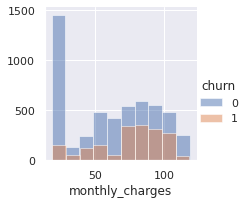

In [135]:
g = sns.FacetGrid(churn_df, hue="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

Conforme analisada realizada anteriormente, a variável **monthly_charges** parece ter uma significativa correlação positiva com a rotatividade dos clientes. 

Foi observado que o serviço contratado de internet de fibra ótica parece ser, dentre os serviços existentes, aquele que mais contribui com o aumento do valor mensal cobrado e que, consequentemente, mais influencia na rotatividade.

Ademais, os dados dos ex-clientes parecem indicar a existência de uma distribuição tri-modal composta primeiramente pelos clientes que utilizam-se apenas dos serviços de telefonia, subsequentemente, os clientes que utilizam-se da internet via DSL e, por último, os clientes que se utilizam da internet via fibra ótica.

Com base nas análises acima, as seguintes ações serão tomadas

*   Variável **gender** será eliminada;
*   Variável **total_charges** será elimnada;
*   As variáveis categoricas serão posteriormente tratadas



In [136]:
del churn_df["gender"]
churn_df["total_charges"] = churn_df["monthly_charges"] * churn_df["tenure"]
churn_df["churn"] = churn_df.pop("churn")


### 3.2. Visualizações Unimodais Dados Numéricos

Vamos criar agora um histograma para cada atributo do dataset. Veremos que os atributos age, pedi e test seguem uma distribuição exponencial, e que as colunas mass e press seguem uma distribuição aproximadamente normal.

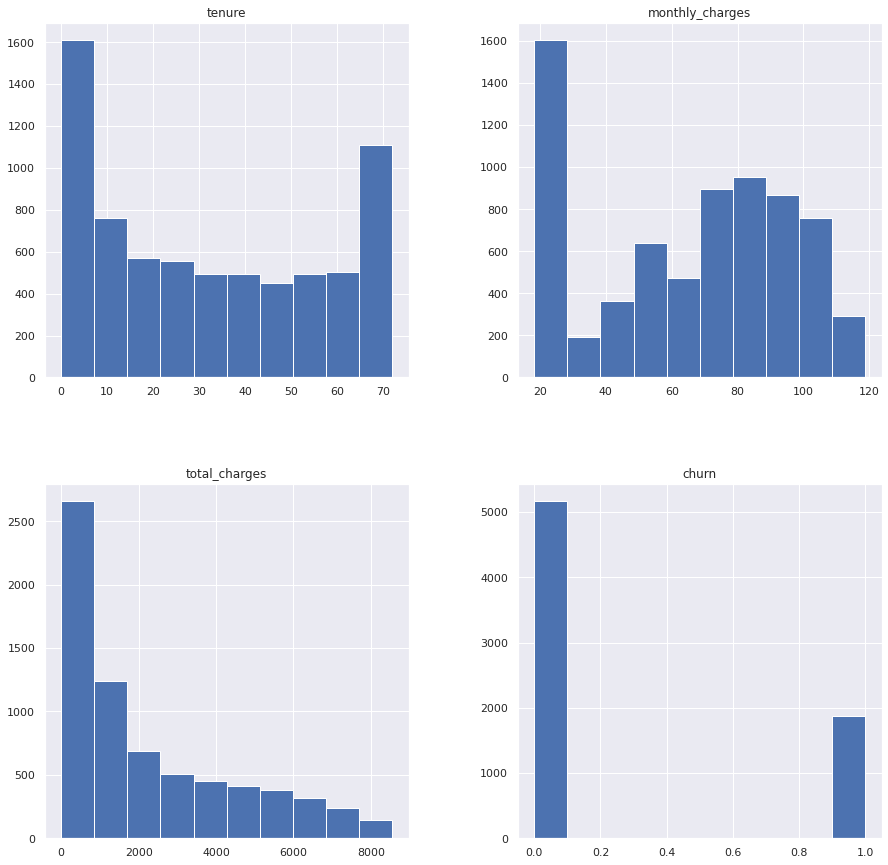

In [137]:
# Histograma
churn_df.hist(figsize = (15,15))
plt.show()

O Gráfico de Densidade, ou Density Plot, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, vamos criar um density plot para cada atributo do dataset.

Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

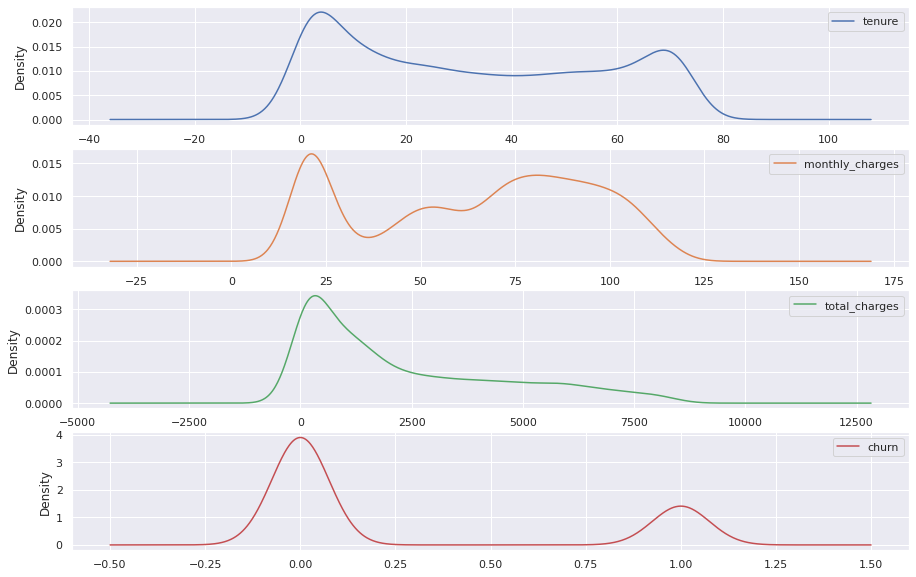

In [138]:
# Density Plot
churn_df.plot(kind = 'density', subplots = True, sharex = False, figsize = (15,10))
plt.show()

Vamos agora trabalhar com boxplots. No **boxblot**, a linha no centro (vermelha) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

*OBS: Se um ponto do dataset é muito distante da média (acima de 3 desvios padrão da média), pode ser considerado outlier.*

Nos gráficos bloxplot, veremos que a dispersão dos atributos do dataset é bem diferente.

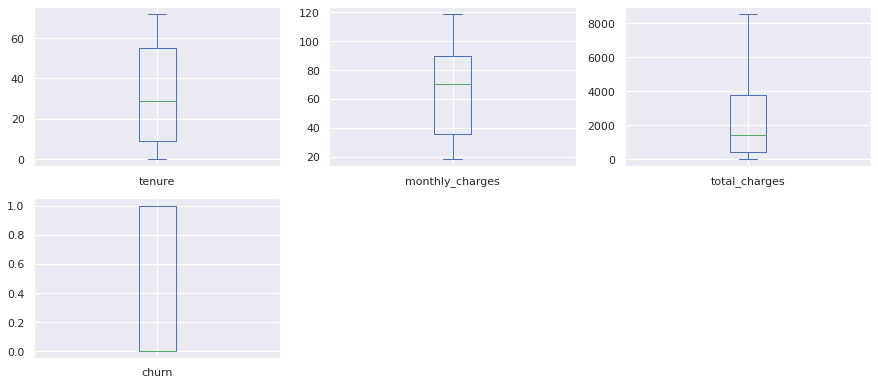

In [139]:
# Boxplot
churn_df.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Ao visualizar as correlações entre os atributos através da matriz de correlação, perceberemos que parece haver alguma estrutura na ordem dos atributos. O azul ao redor da diagonal sugere que os atributos que estão próximos um do outro são geralmente mais correlacionados entre si. Os vermelhos também sugerem alguma correlação negativa moderada, a medida que os atributos 

Vamos agora verificar a covariância entre as variáveis numéricas do dataset. A **covariância** representa como duas variáveis numéricas estão relacionadas. Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis, 
* Próximo de +1: há uma correlação positiva entre as variáveis. 
* 0: não há correlação entre as variáveis.

<i>OBS: Esta informação é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.</i>

Falamos anteriormente da importância da correlação entre os atributos, e agora iremos visualizar esta informação em formato gráfico. A **matriz de correlação** exibe graficamente a correlação entre os atributos numéricos do dataset.estão mais distantes um do outro na ordenação. 

O código a seguir exibe a matriz de correlação.

In [140]:
# Matriz de Correlação com Matplotlib Seaborn
interval_cols = ['tenure', 'monthly_charges', 'total_charges']

phik_overview_df = churn_df.phik_matrix(interval_cols=interval_cols)
phik_overview_df.sort_values(by="churn", inplace=True, axis=0)
phik_overview_df.sort_values(by="churn", inplace=True, axis=1)
sorted_phik_df = churn_df[ phik_overview_df.index ]
phik_overview_df = sorted_phik_df.phik_matrix(interval_cols=interval_cols)
display(phik_overview_df);



,phone_service,multiple_lines,streaming_tv,streaming_movies,device_protection,online_backup,internet_service,tech_support,online_security,partner,senior_citizen,contract,dependents,total_charges,paperless_billing,monthly_charges,payment_method,tenure,churn
phone_service,1.00,1.00,0.11,0.11,0.10,0.10,0.28,0.11,0.11,0.02,0.00,0.00,0.00,0.20,0.02,0.83,0.00,0.00,0.00
multiple_lines,1.00,1.00,0.59,0.59,0.56,0.56,0.74,0.54,0.54,0.09,0.09,0.24,0.01,0.50,0.10,0.71,0.17,0.37,0.02
streaming_tv,0.11,0.59,1.00,0.97,0.95,0.95,0.95,0.95,0.94,0.08,0.11,0.55,0.09,0.56,0.20,0.86,0.28,0.32,0.14
streaming_movies,0.11,0.59,0.97,1.00,0.95,0.95,0.95,0.95,0.94,0.08,0.11,0.55,0.08,0.57,0.20,0.86,0.29,0.33,0.14
device_protection,0.10,0.56,0.95,0.95,1.00,0.95,0.94,0.95,0.95,0.10,0.11,0.63,0.09,0.57,0.20,0.83,0.30,0.40,0.17
online_backup,0.10,0.56,0.95,0.95,0.95,1.00,0.94,0.95,0.95,0.09,0.11,0.58,0.10,0.57,0.20,0.82,0.29,0.40,0.18
internet_service,0.28,0.74,0.95,0.95,0.94,0.94,1.00,0.95,0.95,0.00,0.16,0.51,0.11,0.51,0.23,0.92,0.32,0.02,0.20
tech_support,0.11,0.54,0.95,0.95,0.95,0.95,0.95,1.00,0.95,0.08,0.14,0.67,0.11,0.53,0.20,0.82,0.32,0.36,0.21
online_security,0.11,0.54,0.94,0.94,0.95,0.95,0.95,0.95,1.00,0.09,0.13,0.64,0.12,0.53,0.21,0.81,0.32,0.37,0.21
partner,0.02,0.09,0.08,0.08,0.10,0.09,0.00,0.08,0.09,1.00,0.02,0.18,0.65,0.43,0.01,0.20,0.24,0.49,0.23


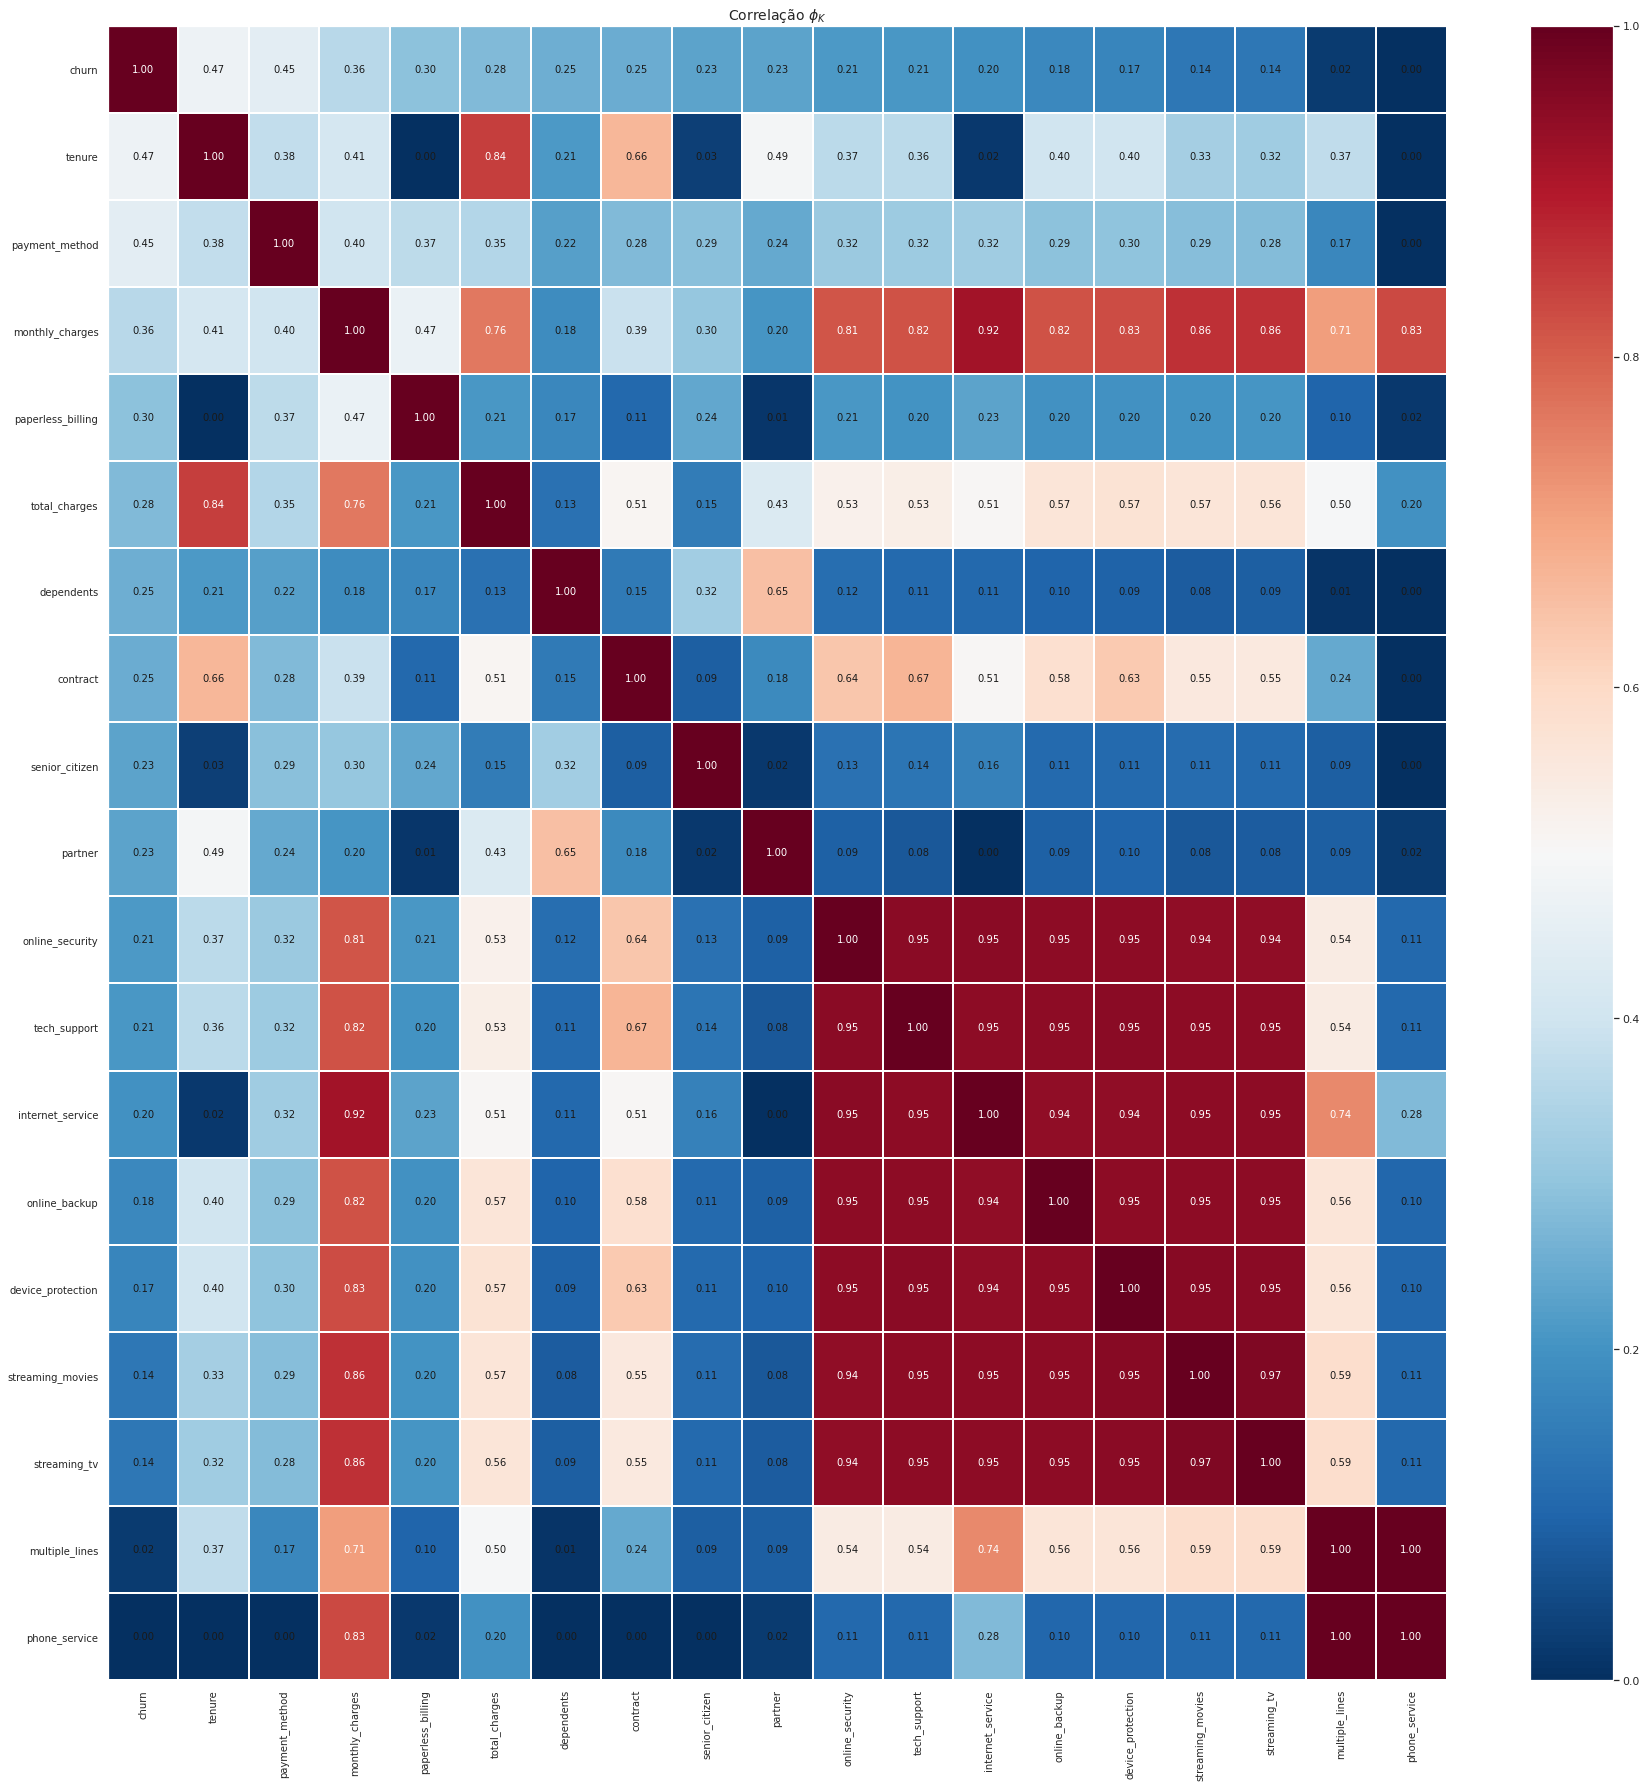

In [141]:


plot_correlation_matrix(
    phik_overview_df.values
,   x_labels          = phik_overview_df.columns
,   y_labels          = phik_overview_df.index
,   vmin              = 0
,   vmax              = 1
,   color_map         = 'RdBu_r'
,   title             = r'Correlação $\phi_K$'
,   figsize=(25,25)
);
plt.tight_layout();


O coeficiente de correlação Phi K consegue calcular as correlações entre variáveis categóricas e numéricas analisando o efeito que as variáveis categóricas possuem sobre as variáveis numéricas intervalares.

Diferente de outros algoritmos de para cálculo de correlação, ele consegue capturar de forma adequada relacionamentos não lineares entre variáveis, mas não consegue indicar a direção do relacionamento, apenas se ele existe e sua intensidade, pois os dados retornados variam entre um intervalo entre 0 e 1.

Por ser um algoritmo ainda novo, a interpretação da intensidade dos relacionamentos pode ser um tanto dificultada. Portanto, as linhas e colunas do dataframe contendo as correlações foram ordenados com base na intensidade do relacionamento com a variável target **churn**. Nesse sentido, as constatações anteriormente realizadas via análise das tabulações cruzadas com a variável target são reforçadas/confirmadas.

Ignorando a primeira coluna/linha (por tratar-se da própria variável target após a ordenação citada acima), podemos verificar que as variáveis que possuem a maior correlação com a mesma são:

- **tenure** indicando que os clientes mais novos possuem maior rotatividade e que, com o passar do tempo, tendem a se fidelizar, conforme análise anterior.

- **monthly_charges** indicando que os clientes que contratam os serviços mais caros (internet de fibra ótica) tendem a ter a maior rotatividade e que clientes que possuem apenas planos telefônicos, tendem a apresentar menor rotatividade (conforme análise anterior).

- **payment_method** indicando que os clientes que realizam pagamento via cheques eletrônicos(depósitos diretos) são os que apresentam a maior rotatividade(conforme análise anterior), possivelmente ligado a facilidade na qual os pagamentos podem ser sustados sem necessidade de contato com a operadora.

Existe uma alta correlação entre os diferentes serviços oferecidos e uma correlação dos mesmos com os valores mensais cobrados. Essa relação possivelmente pode ser explicada sobre o efeito que a contratação desses serviços possuem sobre o valor da mensalidade. Nesse sentido, é difícil interpretar as correlações reportadas por falta de uma intuição adequada sobre o seu significado, efeitos e características.

Mais detalhes sobre o coeficiente Phi K podem ser encontrados no link abaixo, inclusive o artigo no qual o mesmo foi apresentado.

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

## 4. Pré-Processamento de dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), limpeza de dados, transformações como one-hot-encoding, seleção de características (feature selection), entre outras não mostradas neste notebook. Lembre-se de não criar uma versão padronizada/normalizada dos dados neste momento (apesar de serem operações de pré-processamento) para evitar o Data Leakage.

### 4.1. Tratamento das variáveis categóricas

Dado o elevado número de variáveis categóricas presentes no data set, iremos adotar a estratégia de **Dummy Encoding** para tranformar os dados categóricos em numéricos e posteriormente removendo as colunas redundantes.


In [142]:
# transformando variáveis booleanas em numéricas (dummy encoding não é necessário)
for feature in BOOLEAN_FEATURES:
  churn_df[feature] = churn_df[feature].map(BOOLEAN_MAP)

# realizando o dummy encoding usando pandas
dummy_df = pd.get_dummies(
    data        = churn_df[CATEGORICAL_FEATURES]
,   prefix      = CATEGORICAL_FEATURES
,   prefix_sep  = "="
)

# concatenando as variáveis boleanas, categóricas codificads, numéricas e variável target num novo dataset
churn_df = pd.concat([
    churn_df[ BOOLEAN_FEATURES ]
,   dummy_df
,   churn_df[ NUMERICAL_FEATURES ]
,   churn_df[ TARGET_VARIABLE ]
], axis=1)

# removendo variáveis equivalentes internet_service=No = 1
del churn_df["device_protection=No internet service"]
del churn_df["streaming_tv=No internet service"]
del churn_df["tech_support=No internet service"]
del churn_df["online_backup=No internet service"]
del churn_df["streaming_movies=No internet service"]
del churn_df["online_security=No internet service"]

# removendo variáveis equivalentes phone_service=0
del churn_df["multiple_lines=No phone service"]

# removendo variáveis codificada tornadas redundantes pelas deleções acima
del churn_df["multiple_lines=No"]
del churn_df["online_security=No"]
del churn_df["online_backup=No"]
del churn_df["device_protection=No"]
del churn_df["tech_support=No"]
del churn_df["streaming_tv=No"]
del churn_df["streaming_movies=No"]
del churn_df["internet_service=No"]


As colunas resultantes foram renomeadas para melhorar a legibilidade do dataframe.

In [143]:
new_column_names = {
    'multiple_lines=Yes'                       : 'multiple_lines'
,   'internet_service=DSL'                     : 'dsl'
,   'internet_service=Fiber optic'             : 'fiber_optic'
,   'online_security=Yes'                      : 'online_security'
,   'online_backup=Yes'                        : 'online_backup'
,   'device_protection=Yes'                    : 'device_protection'
,   'tech_support=Yes'                         : 'tech_support'
,   'streaming_tv=Yes'                         : 'streaming_tv'
,   'streaming_movies=Yes'                     : 'streaming_movies'
,   'contract=Month-to-month'                  : 'monthly_contract'
,   'contract=One year'                        : 'one_year_contract'
,   'contract=Two year'                        : 'two_year_contract'
,   'payment_method=Bank transfer (automatic)' : 'bank_transfer'
,   'payment_method=Credit card (automatic)'   : 'credit_card'
,   'payment_method=Electronic check'          : 'electronic_check'
,   'payment_method=Mailed check'              : 'mailed_check'
}
churn_df.rename(columns=new_column_names, inplace=True)

## 4.2 Feature Engineering

Foi verificado anteriormente que as variáveis **tenure**, **monthly_charges** e **payment_method** possuiam correlação significativa com a variável target.

As três variáveis serão combinadas para tentar criar variáveis com melhor poder explicativo.

In [144]:
orig_df = churn_df.copy()

In [145]:

churn_df = orig_df.copy()

rows, cols = churn_df.shape
# client factor
# A análise das tabulações cruzadas revelou que a existência de parceiro e dependentes tendem a fidelizar o cliente.
# Em contrapartida, observou-se que clientes na terceira idade proporcionalmente tendem a cancelar os serviços
# de maneira mais frequente.
# A expectativa é de que quanto maior for o client_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=0.2, size=rows)
churn_df["client_factor"] = (
    noise_term
+   np.exp(churn_df["senior_citizen"]) # senior_citizen=1 piora as p
+   np.exp(np.abs(1-churn_df["partner"]))
+   np.exp(np.abs(1-churn_df["dependents"]))
) / 3.0

# internet factor
noise_term = np.random.normal(loc=0.0, scale=0.2, size=rows)
churn_df["internet_factor"] = (
    noise_term
+   1 # to represent no internet
+   np.exp(churn_df["dsl"]) 
+   np.exp(churn_df["fiber_optic"])
) / 3.0

# financial factor
noise_term = np.random.normal(loc=0.0, scale=0.2, size=rows)
churn_df["financial_factor"] = (
    noise_term
+   np.exp(churn_df["monthly_contract"]) 
+   np.exp(churn_df["electronic_check"])
+   np.exp(churn_df["paperless_billing"])
) / 3.0

churn_df["churn"] = churn_df.pop("churn")
churn_df.describe()

,senior_citizen,partner,dependents,phone_service,paperless_billing,multiple_lines,dsl,fiber_optic,online_security,online_backup,...,credit_card,electronic_check,mailed_check,tenure,monthly_charges,total_charges,client_factor,internet_factor,financial_factor,churn
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,...,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.16,0.48,0.30,0.90,0.59,0.42,0.34,0.44,0.29,0.34,...,0.22,0.34,0.23,32.37,64.76,2279.58,1.79,1.45,1.85,0.27
std,0.37,0.50,0.46,0.30,0.49,0.49,0.47,0.50,0.45,0.48,...,0.41,0.47,0.42,24.56,30.09,2264.73,0.54,0.24,0.59,0.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,18.25,0.00,0.78,0.77,0.79,0.00
25%,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,9.00,35.50,394.00,1.47,1.46,1.51,0.00
50%,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,29.00,70.35,1393.60,2.05,1.55,1.68,0.00
75%,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,0.00,55.00,89.85,3786.10,2.17,1.60,2.21,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,72.00,118.75,8550.00,2.97,1.80,2.94,1.00


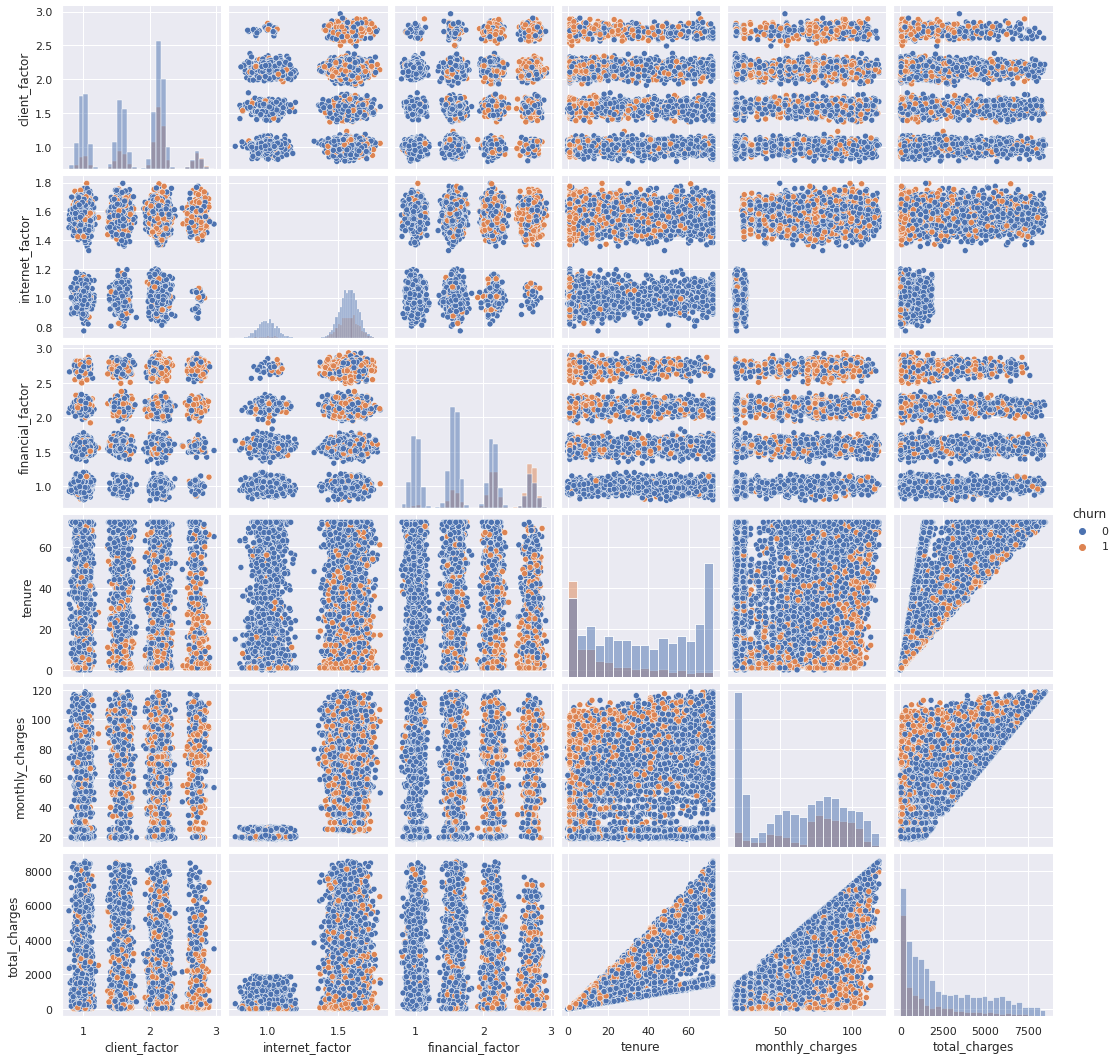

In [146]:
scatter_vars = [
  "client_factor", 
  "internet_factor", 
  "financial_factor", 
  "tenure",
  "monthly_charges",
  "total_charges"
]

sns.pairplot(
    churn_df
,   diag_kind = "hist"    
,   vars      = scatter_vars
,   hue       = "churn"
)


### 4.3. Separação em conjunto de treino e conjunto de teste

Para evitar que os processo de treino do modelo resulte em um modelo sobreajustado aos dados (overfitting) é importante testar o modelo com dados ainda não vistos. Modelos sobreajustados tendem a ter uma performance pior estes dados, sendo isso um forte indicativo de que o modelo não foi capaz de generalizar seu poder preditivo.

É uma boa prática usar um conjunto de teste, uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final.

Trata-se de um boa prática usada para avaliação sistemática da performance do modelo.

Usaremos 80% do conjunto de dados para modelagem e treino, e guardaremos 20% para teste, usando a estratégia train-test-split.

## 4.3 Normalização

Dado as significativas diferenças entre as escalas das variáveis, a ausência de outliers presentes no conjunto de dados e a presença de variáveis numéricas geradas a partir de dados categóricos usando dummy encoding(representadas como 0's ou 1's), o conjunto de dados será tratado usando o procedimento conhecido como normalização. A normalização irá sempre mapear o intervalo de valores observados nas variávéis para o intervalo entre 0 e 1.

A normalização feita abaixo precisará ser posteriormente refeita no pipeline, pois a separação do conjunto de dados de treino e teste ainda não foi realizada, o que poderia ser caracterizado como um data leakage da variável target.

In [147]:
all_but_target = churn_df.columns.difference([TARGET_VARIABLE])
X = churn_df[all_but_target].values
y = churn_df[TARGET_VARIABLE].values

X_train, X_test, y_train, y_test = train_test_split(
    X
,   y
,   test_size     = TEST_PCT_SIZE
,   shuffle       = True
,   random_state  = RANDOM_STATE
,   stratify      = y # com estratificação
)

X_train_df = pd.DataFrame(X_train, columns=all_but_target)
X_test_df = pd.DataFrame(X_test, columns=all_but_target)
y_train_df = pd.DataFrame(y_train, columns=[TARGET_VARIABLE])
y_test_df = pd.DataFrame(y_test, columns=[TARGET_VARIABLE])

## 5. Modelos de Classificação

### 5.1. Criação e avaliação de modelos: linha base

Não sabemos de antemão quais modelos performarão bem neste conjunto de dados. Assim, usaremos a validação cruzada 10-fold (já detalhada anteriormente) e avaliaremos os modelos usando a métrica de acurácia. Vamos inicialmente configurar os parâmetros de número de folds e métrica de avaliação.

In [148]:
# Parâmetros e partições da validação cruzada estratificada
kfold = StratifiedKFold(
    n_splits      = K_FOLDS
,   shuffle       = True
,   random_state  = RANDOM_STATE
) 
# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.3f' % x)


In [149]:
# Configuração do pipeline

# Os transformadores numéricos são utilizado spara processamento de todas as variáveis não categóricas.
numeric_transformer = Pipeline([
  ("scaler", StandardScaler())    
])

column_transformer = ColumnTransformer(
  transformers = [
    ("num", numeric_transformer, NUMERICAL_FEATURES_AFTER_FEAT_ENG)
  ],
  # importante usar passthrough quando nem todos os atributos forem processados
  remainder="passthrough" 
)

# Este pipelie será ajustado diversas vezes durante o processo de otimização dos hiper parâmetros.
pipeline = Pipeline([
    # a primeira fase consiste no pré-processamento das variáveis numéricas
    ("feature_scaling", column_transformer),
    # redução de dimesionalidade
    ("reduce_dim", PCA()),
    # O algoritmo de regressão e seus parâmetros serão configurados via gridsearch
    ("classifier", SVC())
])

In [150]:
def search_hyperparameters(param_grid, num_iter, algo):
  model_settings = MODEL_SETTINGS[algo]
  if model_settings["train"]:
    grid = RandomizedSearchCV(
        estimator           = pipeline
    ,   param_distributions = param_grid
    ,   scoring             = SCORING_METRIC
    ,   cv                  = kfold
    ,   n_iter              = num_iter
    ,   return_train_score  = RETURN_TRAIN_SCORE
    )
    grid.fit(X_train_df, y_train_df)
    save_model(grid, model_settings["model_file"])
  else:
    grid = read_model(model_settings["model_file"])
  print(f"Melhor ROCAUC: {grid.best_score_}")
  print("Melhor estimador -> ")
  pprint(grid.best_params_)
  results_df = pd.DataFrame(grid.cv_results_)
  results_df.to_excel(OUTPUT_TRAINING_FILE_TMPLT.replace("{algo}", algo))
  return grid, results_df

def plot_mean_std(results_df, param_name, new_name):
  results_df[new_name] = results_df[param_name]
  return sns.scatterplot(
      data=results_df
  ,   x="mean_test_score"
  ,   y="std_test_score"
  ,   hue=new_name
  )
  
def show_top_n(results_df, n, column_mapping):
  results_df.sort_values("mean_test_score", inplace=True, ascending=False)
  columns = {new_name: results_df[col_name] for new_name, col_name in column_mapping.items()}
  params_df = pd.DataFrame(columns)
  display(params_df.head(n))
  return params_df

def report_results(grid):
  y_train_hat         = grid.best_estimator_.predict(X_train_df)
  y_test_hat          = grid.best_estimator_.predict(X_test_df)
  
  y_train_prob        = grid.best_estimator_.predict_proba(X_train_df)[:,1]
  y_test_prob         = grid.best_estimator_.predict_proba(X_test_df)[:,1]
  
  acc_train_score     = accuracy_score(y_train, y_train_hat)
  acc_test_score      = accuracy_score(y_test, y_test_hat)  
  
  f1_train_score      = f1_score(y_train, y_train_hat)
  f1_test_score       = f1_score(y_test, y_test_hat)
  
  rocauc_train_score  = roc_auc_score(y_train, y_train_prob)
  rocauc_test_score   = roc_auc_score(y_test, y_test_prob)
  
  print(f"== Train ACC Score    :  {acc_train_score} ===")
  print(f"== Test ACC Score     :  {acc_test_score} ===")
  print(f"== Train F1 Score     :  {f1_train_score} ===")
  print(f"== Test F1 Score      :  {f1_test_score} ===")
  print(f"== Train ROCAUC Score :  {rocauc_train_score} ===")
  print(f"== Test ROCAUC Score  :  {rocauc_test_score} ===")
  
  plot_confusion_matrix(
      grid.best_estimator_
  ,   X_test_df
  ,   y_test_df
  )
  plt.show()
  plot_roc_curve(
      grid.best_estimator_
  ,   X_test_df
  ,   y_test_df
  )
  plt.show()
  print(classification_report(y_test, y_test_hat))

def save_model(grid, file_name):
  import pickle
  data = {
    "best_score_"     : grid.best_score_
  , "best_params_"    : grid.best_params_
  , "best_estimator_" : grid.best_estimator_
  , "cv_results_"     : grid.cv_results_
  , "grid"            : grid
  }  
  with open(file_name, "wb") as fh:
    pickle.dump(data, fh)

def read_model(file_name):
  import pickle
  with open(file_name, "rb") as fh:
    data                  = pickle.load(fh)
  grid                  = data["grid"]
  grid.best_score_      = data["best_score_"]
  grid.best_params_     = data["best_params_"]
  grid.best_estimator_  = data["best_estimator_"]
  grid.cv_results_      = data["cv_results_"]
  return grid


In [151]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # Logistic Regression
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["elasticnet"],
    "classifier__class_weight"      : ["balanced"],
    "classifier__solver"            : ["saga"],
    "classifier__l1_ratio"          : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  },
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["none"],
    "classifier__class_weight"      : ["balanced"],
  }  
]
if QUICK_RUN:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 20, "logreg")
else:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 200, "logreg")

Melhor ROCAUC: 0.8438666388507604
Melhor estimador -> 
{'classifier': LogisticRegression(class_weight='balanced', n_jobs=-1, penalty='none'),
 'classifier__class_weight': 'balanced',
 'classifier__n_jobs': -1,
 'classifier__penalty': 'none',
 'feature_scaling__num__scaler': MinMaxScaler(),
 'reduce_dim': 'passthrough'}


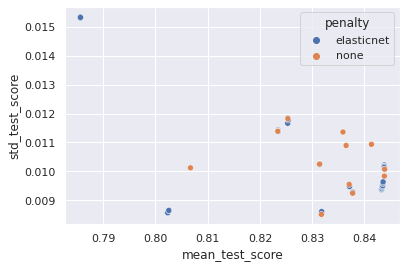

In [152]:
plot_mean_std(logreg_results_df, "param_classifier__penalty", "penalty")

Os melhores resultados obtidos com a regressão logística obtiveram um score F1 perto de 0.632 com um desvio padrão da métrica calculado aproximadamente 0.02.

In [153]:
column_mapping={
    "mean_score"      : "mean_test_score"
,   "std_score"       : "std_test_score"
,   "l1_ratio"        : "param_classifier__l1_ratio"
,   "penalty"         : "param_classifier__penalty"
,   "feature_scaling" : "param_feature_scaling__num__scaler"
,   "reduce_dim"      : "param_reduce_dim"
}
logreg_params_df = show_top_n(logreg_results_df, 50, column_mapping)

,mean_score,std_score,l1_ratio,penalty,feature_scaling,reduce_dim
136,0.844,0.010,NaN,none,MinMaxScaler(),passthrough
128,0.844,0.010,1.000,elasticnet,StandardScaler(),passthrough
140,0.844,0.010,NaN,none,StandardScaler(),passthrough
56,0.844,0.010,0.400,elasticnet,StandardScaler(),passthrough
68,0.844,0.010,0.500,elasticnet,StandardScaler(),passthrough
44,0.844,0.010,0.300,elasticnet,StandardScaler(),passthrough
80,0.844,0.010,0.600,elasticnet,StandardScaler(),passthrough
32,0.844,0.010,0.200,elasticnet,StandardScaler(),passthrough
20,0.844,0.010,0.100,elasticnet,StandardScaler(),passthrough
92,0.844,0.010,0.700,elasticnet,StandardScaler(),passthrough


Os melhores resultados obtidos não usaram nenhum tipo de normalização ou padronização dos dados e o uso de redução de dimensionalidade para 5 features via PCA parece ter um efeito positivo na maioria dos casos

== Train ACC Score    :  0.7484787018255578 ===
== Test ACC Score     :  0.738760056791292 ===
== Train F1 Score     :  0.630071599045346 ===
== Test F1 Score      :  0.6187845303867403 ===
== Train ROCAUC Score :  0.8489676999376897 ===
== Test ROCAUC Score  :  0.8427501975485603 ===


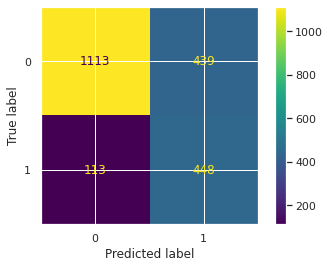

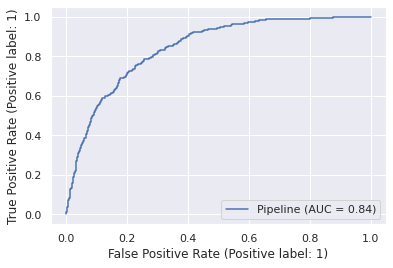

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113



In [154]:
report_results(logreg_grid)

<<Conclusão>>

In [155]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # KNeighborsClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [KNeighborsClassifier()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__algorithm"         : ["kd_tree"],
    "classifier__metric"            : ["minkowski"],
    "classifier__p"                 : [0.5, 1.0, 1.5, 2.0], # manhattan, euclidean
    "classifier__n_neighbors"       : [5, 7, 10, 13, 15, 17, 20],
    "classifier__weights"           : ["uniform", "distance"]
  }  
]
if QUICK_RUN:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 20, "knn")
else:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 200, "knn")

Melhor ROCAUC: 0.8265074043561217
Melhor estimador -> 
{'classifier': KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=20, p=1.0),
 'classifier__algorithm': 'kd_tree',
 'classifier__metric': 'minkowski',
 'classifier__n_jobs': -1,
 'classifier__n_neighbors': 20,
 'classifier__p': 1.0,
 'classifier__weights': 'uniform',
 'feature_scaling__num__scaler': StandardScaler(),
 'reduce_dim': 'passthrough'}


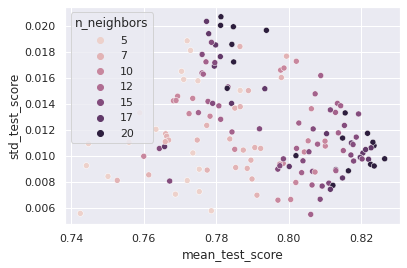

In [156]:
plot_mean_std(knn_results_df, "param_classifier__n_neighbors", "n_neighbors")

Os melhores resultados obtidos com o algoritmo KNN obtiveram um score F1 inferior a 0.6 com um desvio padrão da métrica calculado em aproximadamente 0.03.

In [157]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "n_neighbors"     : "param_classifier__n_neighbors"
, "minkowski-p"     : "param_classifier__p"
, "weights"         : "param_classifier__weights"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
knn_params_df = show_top_n(knn_results_df, 50, column_mapping)

,mean_score,std_score,n_neighbors,minkowski-p,weights,feature_scaling,reduce_dim
127,0.827,0.010,20,1.000,uniform,StandardScaler(),passthrough
165,0.824,0.009,20,1.500,distance,StandardScaler(),passthrough
37,0.824,0.011,20,1.000,distance,StandardScaler(),PCA(n_components=10)
75,0.823,0.011,20,1.000,distance,StandardScaler(),PCA(n_components=5)
79,0.823,0.011,17,1.000,uniform,StandardScaler(),passthrough
100,0.823,0.009,20,2.000,distance,StandardScaler(),passthrough
43,0.822,0.010,17,1.500,uniform,StandardScaler(),passthrough
16,0.822,0.012,20,2.000,distance,StandardScaler(),PCA(n_components=5)
141,0.821,0.010,17,1.000,uniform,MinMaxScaler(),passthrough
67,0.821,0.010,17,2.000,uniform,StandardScaler(),passthrough


Os melhores resultados obtidos utilizaram-se de 13 ou mair vizinhos e a redução de dimensionalidade PCA não foi utilizada. Os melhores resultados tipicamente utilizaram o parâmetro p da métrica de Minkowski menor do que 2 na maioria dos casos (indicando que a distância euclidiana não é adequada para uso nesse conjunto de dados).

== Train ACC Score    :  0.8123732251521298 ===
== Test ACC Score     :  0.7931850449597728 ===
== Train F1 Score     :  0.6172941663218866 ===
== Test F1 Score      :  0.587346553352219 ===
== Train ROCAUC Score :  0.8616046476088194 ===
== Test ROCAUC Score  :  0.8236115322417626 ===


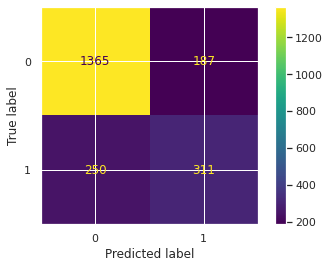

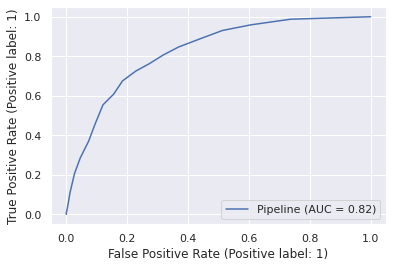

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1552
           1       0.62      0.55      0.59       561

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.72      2113
weighted avg       0.79      0.79      0.79      2113



In [158]:
report_results(knn_grid)

O cômputo do score F1 usando o conjunto de treinamento indica claramente que ocorreu overfitting na parametrização usada para o algoritmo KNN.

In [159]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GaussianNB
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [GaussianNB()],
    "classifier__var_smoothing"     : [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
  }  
]
if QUICK_RUN:
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 20, "nb")
else:  
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 200, "nb")

Melhor ROCAUC: 0.8329852272751318
Melhor estimador -> 
{'classifier': GaussianNB(var_smoothing=0.1),
 'classifier__var_smoothing': 0.1,
 'feature_scaling__num__scaler': StandardScaler(),
 'reduce_dim': 'passthrough'}


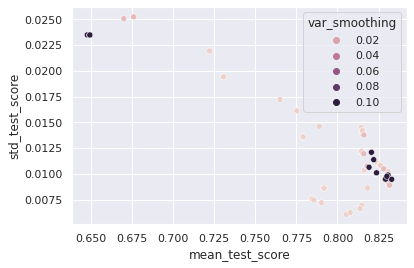

In [160]:
plot_mean_std(nb_results_df, "param_classifier__var_smoothing", "var_smoothing")

Os melhores resultados obtidos com o algoritmo KNN obtiveram um score F1 superior a 0.62 com um desvio padrão da métrica calculado em aproximadamente 0.018

In [161]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "var_smoothing"   : "param_classifier__var_smoothing"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
pd.set_option('display.float_format', lambda x: '%0.10f' % x)
nb_params_df = show_top_n(nb_results_df, 50, column_mapping)
pd.set_option('display.float_format', lambda x: '%0.3f' % x)

,mean_score,std_score,var_smoothing,feature_scaling,reduce_dim
104,0.8329852273,0.0094624946,0.1000000000,StandardScaler(),passthrough
92,0.8316520319,0.0088916785,0.0100000000,StandardScaler(),passthrough
0,0.8312025172,0.0091272949,0.0000000010,passthrough,passthrough
80,0.8311835285,0.0088823252,0.0010000000,StandardScaler(),passthrough
68,0.8311354082,0.0088887560,0.0001000000,StandardScaler(),passthrough
64,0.8311265520,0.0089003042,0.0001000000,MinMaxScaler(),passthrough
52,0.8311265499,0.0088950032,0.0000100000,MinMaxScaler(),passthrough
40,0.8311265499,0.0088945709,0.0000010000,MinMaxScaler(),passthrough
56,0.8311265478,0.0088911349,0.0000100000,StandardScaler(),passthrough
4,0.8311252820,0.0088921701,0.0000000010,MinMaxScaler(),passthrough


O algoritmo de NaiveBayes não possui muitos hiperparâmetros e comporta-se basicamente de maneira indiferente quanto a aplicação ou não do procedimento de normalização ou padronização.

A redução de dimensionalidade, via PCA não ajuda em nada no algoritmo.

O conjunto de dados, quando inicialmente analisado, parecia ser um bom candidato para aplicação deste algoritmo devido a elevada presença de variáveis categóricas, entretanto, a performance observada do mesmo foi inferior à performance da regressão logística, até o momento o melhor algoritmo observado.

== Train ACC Score    :  0.740973630831643 ===
== Test ACC Score     :  0.735447231424515 ===
== Train F1 Score     :  0.6205052005943537 ===
== Test F1 Score      :  0.6093640810621942 ===
== Train ROCAUC Score :  0.833947993657516 ===
== Test ROCAUC Score  :  0.8245320855614974 ===


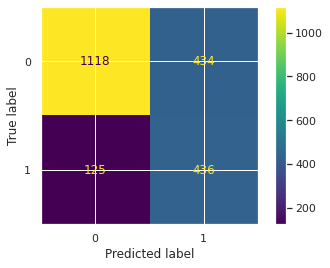

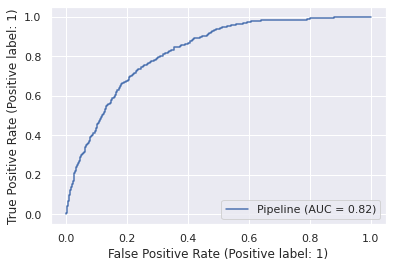

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1552
           1       0.50      0.78      0.61       561

    accuracy                           0.74      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.79      0.74      0.75      2113



In [162]:
report_results(nb_grid)

In [163]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # DecisionTreeClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [DecisionTreeClassifier()],
    "classifier__class_weight"      : [None, "balanced"],
    "classifier__criterion"         : ["gini", "entropy"],
    "classifier__splitter"          : ["best", "random"],
    "classifier__max_features"      : [None, "auto", "sqrt", "log2"],
  }  
]
if QUICK_RUN:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 20, "dt")
else:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 200, "dt")

Melhor ROCAUC: 0.6713255643762408
Melhor estimador -> 
{'classifier': DecisionTreeClassifier(criterion='entropy', max_features='sqrt'),
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_features': 'sqrt',
 'classifier__splitter': 'best',
 'feature_scaling__num__scaler': MinMaxScaler(),
 'reduce_dim': 'passthrough'}


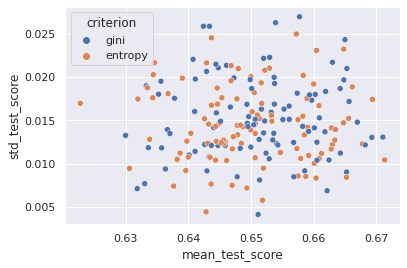

In [164]:
plot_mean_std(dt_results_df, "param_classifier__criterion", "criterion")

Os melhores resultados obtidos com o algoritmo de Árvore de Decisões obtiveram um score F1 com cerca de 0.50 com um desvio padrão da métrica calculado em aproximadamente 0.003

Surpreendentemente, o algoritmo se comporta pior do que a regressão logística.

In [165]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "class_weight"    : "param_classifier__class_weight"
, "criterion"       : "param_classifier__criterion"
, "splitter"        : "param_classifier__splitter"
, "max_features"    : "param_classifier__max_features"
}
dt_params_df = show_top_n(dt_results_df, 50, column_mapping)

,mean_score,std_score,feature_scaling,reduce_dim,class_weight,criterion,splitter,max_features
88,0.671,0.010,MinMaxScaler(),passthrough,None,entropy,best,sqrt
134,0.671,0.013,passthrough,PCA(n_components=10),None,gini,best,None
59,0.669,0.017,MinMaxScaler(),passthrough,balanced,entropy,best,None
74,0.669,0.013,passthrough,passthrough,balanced,gini,best,None
140,0.668,0.012,StandardScaler(),passthrough,balanced,gini,best,None
108,0.668,0.012,passthrough,passthrough,balanced,entropy,random,None
26,0.667,0.015,passthrough,passthrough,balanced,gini,best,auto
170,0.666,0.019,StandardScaler(),passthrough,balanced,entropy,best,None
13,0.666,0.017,passthrough,PCA(n_components=5),None,gini,random,auto
68,0.666,0.015,passthrough,passthrough,balanced,entropy,best,None


O algoritmo de Árvore de Decisão comportou-se melhor com o critério *gini* e parece ter se beneficiado do procedimento de redução de dimensionalidade usando PCA. O balanceamento de classes parece ter ajudado também no processo de treino.

== Train ACC Score    :  0.8513184584178499 ===
== Test ACC Score     :  0.7188831045906294 ===
== Train F1 Score     :  0.7228733459357278 ===
== Test F1 Score      :  0.46678635547576297 ===
== Train ROCAUC Score :  0.8128481738340452 ===
== Test ROCAUC Score  :  0.6373347253615598 ===


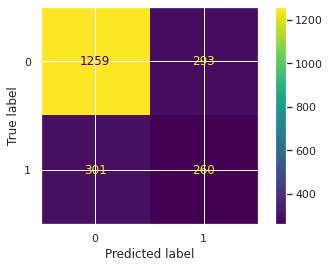

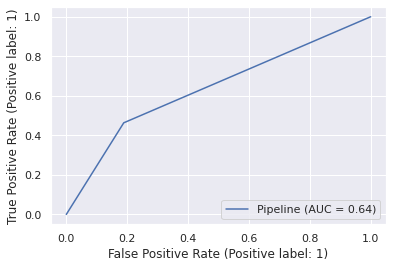

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1552
           1       0.47      0.46      0.47       561

    accuracy                           0.72      2113
   macro avg       0.64      0.64      0.64      2113
weighted avg       0.72      0.72      0.72      2113



In [166]:
report_results(dt_grid)

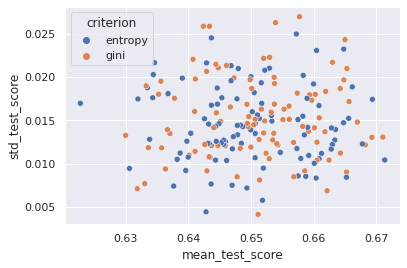

In [167]:
plot_mean_std(dt_results_df, "param_classifier__criterion", "criterion")

Assim como para o algoritmo KNN, O cômputo do score F1 usando o conjunto de treinamento indica claramente que ocorreu overfitting na parametrização usada para o algoritmo de Árvore de Decisões.

In [168]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # SVC
  {
    "feature_scaling__num__scaler"  : [MinMaxScaler(), StandardScaler()], # SVC precisa ter os argumentos escalonados para uma melhor performance
    "reduce_dim"                    : ["passthrough", PCA(n_components=5), PCA(n_components=10)],
    "classifier"                    : [SVC(probability=True)],
    "classifier__kernel"            : ["linear","rbf"],
    "classifier__gamma"             : ["scale", "auto"],
    "classifier__class_weight"      : ["balanced"],
    #"classifier__C"                 : [0.0, 0.5, 1.0, 1.5, 2.0],
  }  
]
if QUICK_RUN:
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 5, "svm")
else:  
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 50, "svm")

Melhor ROCAUC: 0.8378259657622534
Melhor estimador -> 
{'classifier': SVC(class_weight='balanced', gamma='auto', probability=True),
 'classifier__class_weight': 'balanced',
 'classifier__gamma': 'auto',
 'classifier__kernel': 'rbf',
 'feature_scaling__num__scaler': MinMaxScaler(),
 'reduce_dim': 'passthrough'}


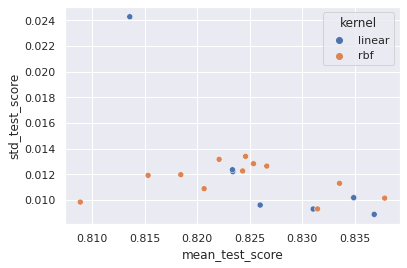

In [169]:
plot_mean_std(svm_results_df, "param_classifier__kernel", "kernel")

Surpreendentemente, o SVM com kernel linear se comportou melhor do que o kernel de *radial basis function*, usado por padrão.

Os melhores scores F1 obtidos

In [170]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "gamma"           : "param_classifier__gamma"
, "kernel"          : "param_classifier__kernel"
}
svm_params_df = show_top_n(svm_results_df, 50, column_mapping)

,mean_score,std_score,feature_scaling,reduce_dim,gamma,kernel
18,0.838,0.010,MinMaxScaler(),passthrough,auto,rbf
16,0.837,0.009,StandardScaler(),PCA(n_components=5),auto,linear
4,0.837,0.009,StandardScaler(),PCA(n_components=5),scale,linear
17,0.835,0.010,StandardScaler(),PCA(n_components=10),auto,linear
5,0.835,0.010,StandardScaler(),PCA(n_components=10),scale,linear
21,0.834,0.011,StandardScaler(),passthrough,auto,rbf
20,0.831,0.009,MinMaxScaler(),PCA(n_components=10),auto,rbf
2,0.831,0.009,MinMaxScaler(),PCA(n_components=10),scale,linear
14,0.831,0.009,MinMaxScaler(),PCA(n_components=10),auto,linear
23,0.827,0.013,StandardScaler(),PCA(n_components=10),auto,rbf


== Train ACC Score    :  0.7129817444219066 ===
== Test ACC Score     :  0.702318977756744 ===
== Train F1 Score     :  0.6063977746870653 ===
== Test F1 Score      :  0.593931568754035 ===
== Train ROCAUC Score :  0.8509647127560592 ===
== Test ROCAUC Score  :  0.8315375939504199 ===


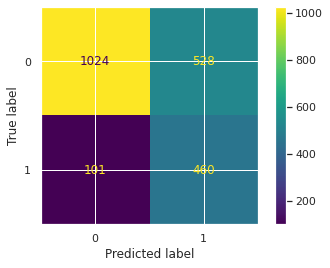

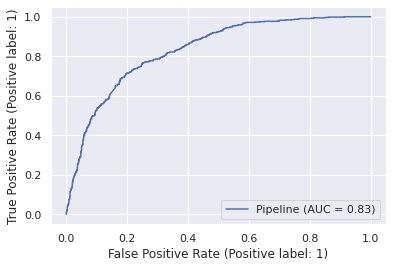

              precision    recall  f1-score   support

           0       0.91      0.66      0.77      1552
           1       0.47      0.82      0.59       561

    accuracy                           0.70      2113
   macro avg       0.69      0.74      0.68      2113
weighted avg       0.79      0.70      0.72      2113



In [171]:
report_results(svm_grid)

In [172]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # AdaBoostClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=5), PCA(n_components=10)],
    "classifier"                      : [AdaBoostClassifier()],
    "classifier__n_estimators"        : [25, 50, 75, 100],
    "classifier__learning_rate"       : [0.001, 0.01, 0.1, 1.0]
  }  
]
if QUICK_RUN:
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 5, "ada")
else:  
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 64, "ada")

Melhor ROCAUC: 0.844023789736871
Melhor estimador -> 
{'classifier': AdaBoostClassifier(learning_rate=0.1, n_estimators=75),
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 75,
 'feature_scaling__num__scaler': MinMaxScaler(),
 'reduce_dim': 'passthrough'}


In [173]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "learning_rate"   : "param_classifier__learning_rate"
}
ada_params_df = show_top_n(ada_results_df, 50, column_mapping)

,mean_score,std_score,feature_scaling,reduce_dim,n_estimators,learning_rate
50,0.844,0.008,MinMaxScaler(),passthrough,75,0.100
29,0.842,0.012,StandardScaler(),passthrough,25,1.000
25,0.842,0.012,MinMaxScaler(),passthrough,25,1.000
48,0.842,0.012,passthrough,passthrough,25,1.000
10,0.841,0.008,passthrough,passthrough,50,0.100
52,0.841,0.008,MinMaxScaler(),passthrough,50,0.100
34,0.840,0.014,passthrough,passthrough,50,1.000
62,0.837,0.012,passthrough,PCA(n_components=5),100,0.100
53,0.837,0.016,StandardScaler(),passthrough,75,1.000
45,0.837,0.011,passthrough,PCA(n_components=10),100,0.100


== Train ACC Score    :  0.8038539553752535 ===
== Test ACC Score     :  0.7884524372929484 ===
== Train F1 Score     :  0.5642181162685894 ===
== Test F1 Score      :  0.5229455709711847 ===
== Train ROCAUC Score :  0.8482492945759603 ===
== Test ROCAUC Score  :  0.8381681046364187 ===


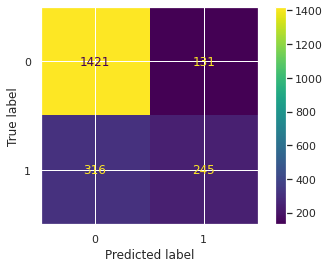

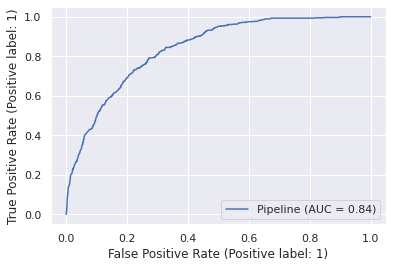

              precision    recall  f1-score   support

           0       0.82      0.92      0.86      1552
           1       0.65      0.44      0.52       561

    accuracy                           0.79      2113
   macro avg       0.73      0.68      0.69      2113
weighted avg       0.77      0.79      0.77      2113



In [174]:
report_results(ada_grid)

In [175]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GradientBoostingClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=5), PCA(n_components=10)],
    "classifier"                      : [GradientBoostingClassifier()],
    "classifier__loss"                : ["log_loss", "deviance", "exponential"],
    "classifier__n_estimators"        : [50, 75, 100, 150],
    "classifier__learning_rate"       : [0.1, 0.3, 0.5, 0.7, 1.0],
    "classifier__max_depth"           : [3, 5, 10],
    "classifier__max_features"        : [None, "sqrt", "log2"]
  }  
]
if QUICK_RUN:
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 10, "gb")
else:  
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 100, "gb")

Melhor ROCAUC: 0.8455807684646214
Melhor estimador -> 
{'classifier': GradientBoostingClassifier(max_features='log2', n_estimators=75),
 'classifier__learning_rate': 0.1,
 'classifier__loss': 'deviance',
 'classifier__max_depth': 3,
 'classifier__max_features': 'log2',
 'classifier__n_estimators': 75,
 'feature_scaling__num__scaler': MinMaxScaler(),
 'reduce_dim': 'passthrough'}


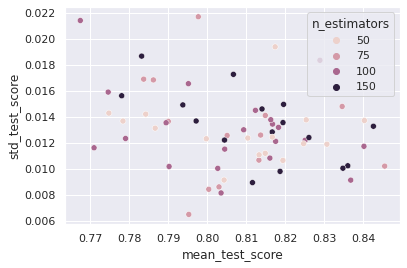

In [176]:
plot_mean_std(gb_results_df, "param_classifier__n_estimators", "n_estimators")

In [177]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "loss"            : "param_classifier__loss"
, "n_estimators"    : "param_classifier__n_estimators"
, "loss"            : "param_classifier__loss"
, "learning_rate"   : "param_classifier__learning_rate"
, "max_depth"       : "param_classifier__max_depth"
, "max_features"    : "param_classifier__max_features"
}
gb_params_df = show_top_n(gb_results_df, 50, column_mapping)

,mean_score,std_score,feature_scaling,reduce_dim,loss,n_estimators,learning_rate,max_depth,max_features
57,0.846,0.010,MinMaxScaler(),passthrough,deviance,75,0.100,3,log2
81,0.843,0.013,StandardScaler(),passthrough,deviance,150,0.100,3,log2
74,0.840,0.014,MinMaxScaler(),passthrough,deviance,50,0.300,3,log2
36,0.840,0.012,passthrough,passthrough,deviance,100,0.100,5,sqrt
41,0.837,0.009,StandardScaler(),PCA(n_components=5),deviance,100,0.100,3,sqrt
10,0.836,0.010,StandardScaler(),PCA(n_components=10),exponential,150,0.100,3,None
90,0.835,0.010,StandardScaler(),PCA(n_components=5),exponential,150,0.100,3,log2
14,0.835,0.015,passthrough,passthrough,exponential,75,0.300,3,None
37,0.831,0.012,passthrough,passthrough,deviance,50,0.500,3,sqrt
54,0.829,0.018,passthrough,PCA(n_components=5),exponential,100,0.300,3,sqrt


== Train ACC Score    :  0.8158215010141988 ===
== Test ACC Score     :  0.8045433033601515 ===
== Train F1 Score     :  0.6129582267689685 ===
== Test F1 Score      :  0.5781409601634321 ===
== Train ROCAUC Score :  0.8629192439340287 ===
== Test ROCAUC Score  :  0.845700792031902 ===


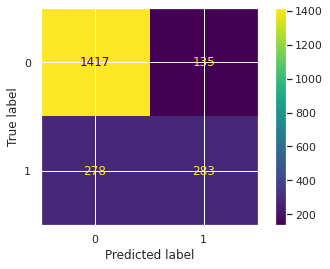

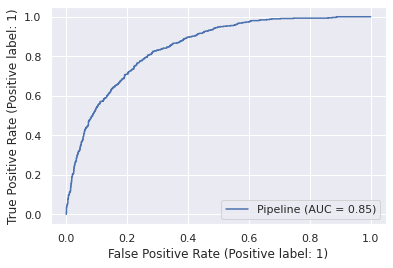

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.68      0.50      0.58       561

    accuracy                           0.80      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



In [178]:
report_results(gb_grid)

In [179]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # RandomForestClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough"], #PCA(n_components=5), PCA(n_components=10)],
    "classifier"                      : [RandomForestClassifier()],
    "classifier__n_estimators"        : [50, 100, 150],
    "classifier__criterion"           : ["gini", "entropy"],
    "classifier__bootstrap"           : [True, False],
    "classifier__n_jobs"              : [-1],
    "classifier__class_weight"        : ["balanced", "balanced_subsample"],
  }
]
if QUICK_RUN:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 10, "rf")
else:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 100, "rf")

Melhor ROCAUC: 0.835839353115944
Melhor estimador -> 
{'classifier': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=150, n_jobs=-1),
 'classifier__bootstrap': True,
 'classifier__class_weight': 'balanced_subsample',
 'classifier__criterion': 'entropy',
 'classifier__n_estimators': 150,
 'classifier__n_jobs': -1,
 'feature_scaling__num__scaler': StandardScaler(),
 'reduce_dim': 'passthrough'}


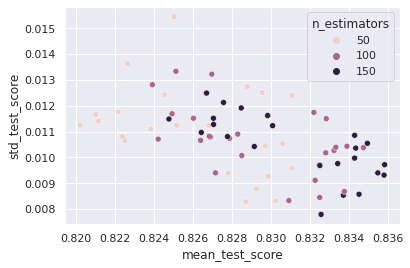

In [180]:
plot_mean_std(rf_results_df, "param_classifier__n_estimators", "n_estimators")

In [181]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "criterion"       : "param_classifier__criterion"
, "bootstrap"       : "param_classifier__bootstrap"
, "class_weight"    : "param_classifier__class_weight"
}
rf_params_df = show_top_n(rf_results_df, 50, column_mapping)

,mean_score,std_score,feature_scaling,reduce_dim,n_estimators,criterion,bootstrap,class_weight
35,0.836,0.010,StandardScaler(),passthrough,150,entropy,True,balanced_subsample
33,0.836,0.009,passthrough,passthrough,150,entropy,True,balanced_subsample
15,0.835,0.009,passthrough,passthrough,150,entropy,True,balanced
16,0.835,0.011,MinMaxScaler(),passthrough,150,entropy,True,balanced
23,0.835,0.010,StandardScaler(),passthrough,100,gini,True,balanced_subsample
7,0.835,0.009,MinMaxScaler(),passthrough,150,gini,True,balanced
24,0.834,0.010,passthrough,passthrough,150,gini,True,balanced_subsample
17,0.834,0.011,StandardScaler(),passthrough,150,entropy,True,balanced
6,0.834,0.010,passthrough,passthrough,150,gini,True,balanced
12,0.834,0.010,passthrough,passthrough,100,entropy,True,balanced


== Train ACC Score    :  0.9018255578093306 ===
== Test ACC Score     :  0.7927117841930904 ===
== Train F1 Score     :  0.7991701244813277 ===
== Test F1 Score      :  0.5465838509316769 ===
== Train ROCAUC Score :  0.9659903081238168 ===
== Test ROCAUC Score  :  0.8302937271440909 ===


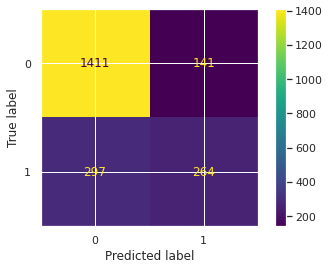

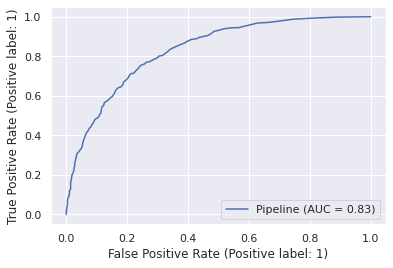

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.65      0.47      0.55       561

    accuracy                           0.79      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



In [182]:
report_results(rf_grid)

<<CONCLUSÃO>>

In [183]:
# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

Vamos adicionar também os algoritmos de ensemble que estudamos:

In [184]:
np.random.seed(7) # definindo uma semente global

# definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# criando os modelos para o VotingClassifier - TODO: você poderia experimentar outras variações aqui!
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os modelos e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

Agora vamos comparar os resultados modelos criados, treinando-os com os dados do conjunto de treino e utilizando a técnica de validação cruzada. Para cada um dos modelos criados, executaremos a validação cruzada e, em seguida, exibiremos a acurácia média e o desvio padrão de cada um. Faremos isso tanto para o dataset original quanto para o dataset sem missings.

In [185]:
# Aqui iremos armazenar os resultados tanto para o dataset original quanto para o dataset sem missings
results = []
names = []

In [186]:
np.random.seed(7) # definindo uma semente global

# Avaliação dos modelos - dataset original

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NameError: ignored

In [ ]:
np.random.seed(7) # definindo uma semente global

# Avaliação dos modelos - dataset sem missings

for name, model in models:
    cv_results = cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

*Dica: organize os resultados numéricos em tabelas, para facilitar a sua comparação.*

Estes resultados sugerem que, para ambos os datasets, diversos modelos têm potencial de trazerem bons resultados, porém, vale observar que estes são apenas valores médios de acurácia, sendo também prudente também observar a distribuição dos resultados dos folds da validação cruzada. Faremos isto comparando os modelos usando boxplots. Os 11 primeiros boxplots são referentes ao dataset original e os seguintes, ao dataset com tratamento de missings.

In [ ]:
# Comparação dos modelos
fig = plt.figure(figsize=(15,10)) 
fig.suptitle('Comparação dos Modelos - Dataset original e com tratamento de missings') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

Os resultados mostram algumas diferenças comparando o dataset original e o dataset com tratamento de missings, parecendo, inicialmente, que o dataset com tratamento de missings gerou melhores resultados (especialmente no KNN: observe a distribuição dos valores). Já considerando a mediana da acurácia marcada como a linha laranja do boxplot, os modelos de regressão logística parecem ter alcançado os melhores resultados.

A seguir, repetiremos este processo usando uma visão padronizada e outra normalizada do conjunto de dados de treinamento.

### 5.2. Criação e avaliação de modelos: dados padronizados e normalizados

Como suspeitamos que as diferentes distribuições dos dados brutos possam impactar negativamente a habilidade de alguns modelos, vamos agora experimentar as visões do dataset padronizado e normalizado, comparando com a visão original do dataset, com e tratamento de missings. Na padronização (*StandardScaler*), os dados serão transformados de modo que cada atributo tenha média 0 e um desvio padrão 1; na normalização (*MinMaxScaler*), cada atributo é redimensionado para um novo intervalo entre 0 e 1.

Para evitar o vazamento de dados (*data leakage*) nestas transformações, vamos usar pipelines que padronizam os dados e constroem o modelo para cada fold de teste de validação cruzada. Dessa forma, podemos obter uma estimativa justa de como cada modelo com dados padronizados pode funcionar com dados não vistos.

*OBS: Repare que neste notebook estamos usando um código mais "limpo" do que nos anteriores.*

In [ ]:
np.random.seed(7) # definindo uma semente global

# Aqui iremos armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Padronização do dataset original
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging]))) 
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Normalização do dataset original
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging]))) 
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines - datasets sem tratamento de missings
print("-- Datasets SEM tratamento de missings")
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Executando os pipelines - datasets com tratamento de missings
print("-- Datasets COM tratamento de missings")
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

Vamos analisar estes resultados graficamente:

*OBS: você pode preferir fazer um experimento com menos variações para comparar melhor os resultados graficamente, ou mesmo incluir neste gráfico algumas linhas verticais para separar as diferentes visões do dataset.*

In [ ]:
# Comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos modelos - Dataset orginal, padronizado e normalizado, com e sem tratamento de missings') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

Neste primeiro experimento, rodamos 66 configurações: 11 diferentes algoritmos e 6 diferentes visões do nosso dataset!

Para o dataset **Sem tratamento de missings**, os melhores modelos em termos de acurácia foram: ET-orig (0,779), Bag-orig (0,77), LR-padr	(0,77), GB-orig	(0,769) e Bag-padr (0,767). Já para o dataset **Com tratamento de missings**, os melhores modelos foram: Vot-orig (0,774), ET-norm (0,77), SVM-norm (0,766), LR-padr (0,764) e RF-norm (0,764).

Vamos agora fazer um **novo experimento**, fazendo o ajuste do SVM e do KNN, variando os seus hiperparâmetros a fim de buscar configurações que possam gerar resultados melhores.

*OBS: Você poderia se aprofundar em outros algoritmos também.*

### 5.3. Ajuste dos Modelos (pipeline + gridsearch)

#### Ajuste do KNN

Vamos começar ajustando parâmetros como o número de vizinhos e as métricas de distância para o KNN. Para tal, tentaremos todos os valores ímpares de k entre 1 a 21 e as métricas de distância euclidiana, manhattan e minkowski. Usando o pipeline, cada valor de k e de distância será avaliado usando a validação cruzada 10-fold no conjunto de dados sem tratamento de missings e com as visões padronizada e normalizada, que mostrou melhores resultados do que os dados originais.

In [ ]:
# Tuning do KNN

# Baseado em https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

np.random.seed(7) # definindo uma semente global

pipelines = []

# definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn]))) # OBS: "steps=" é opcional
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Dataset sem tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)

    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

    # imprime todas as configurações
    #means = grid.cv_results_['mean_test_score']
    #stds = grid.cv_results_['std_test_score']
    #params = grid.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f): %r" % (mean, stdev, param))

# Dataset com tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sm, y_train_sm)

    # imprime a melhor configuração
    print("Com tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

Os resultados mostram que a melhor configuração encontrada utiliza o dataset com tratamento de missings, com dados padronizados, distância de manhattan e k = 15.

#### Ajuste do SVM
Iremos ajustar dois dos principais hiperparâmetros do algoritmo SVM: o valor de C (o quanto flexibilizar a margem) e o tipo de kernel utilizado. No Scikit-Learn, o padrão para o algoritmo SVM (implementado pela classe SVC) é usar o kernel da Função Base Radial (RBF) e o valor C definido como 1.0. 

Iremos testar outros valores para estes hiperparâmetros, e cada combinação de valores será avaliada usando a função GridSearchCV, como fizemos anteriormente para o KNN.

In [ ]:
# Tuning do SVM - DEMORA MUITO ESTE BLOCO DE CÓDIGO

# Baseado em https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

np.random.seed(7) # definindo uma semente global

pipelines = []

# definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm]))) # OBS: "steps=" é opcional
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'SVM__C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
    'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# Dataset sem tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)

    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

    # imprime todas as configurações
    #means = grid.cv_results_['mean_test_score']
    #stds = grid.cv_results_['std_test_score']
    #params = grid.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f): %r" % (mean, stdev, param))

# Dataset com tratamento de missings
for name, model in pipelines:    
    # prepara e executa o GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sm, y_train_sm)

    # imprime a melhor configuração
    print("Com tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

Podemos ver que mesmo a configuração do SVM que alcançou a maior acurácia não supera a acurácia mais alta que conseguimos até o momento, com ensembles.


**Exercício:** Experimente variar os hiperparâmetros de outros algoritmos para verificar se é possível encontrar uma configuração de modelo que supere os melhoresd resultados até o momento.

## 7. Finalização do Modelo

Analisando os resultados até aqui, verificamos que o modelo que mostrou melhor acurácia média para o problema foi o que usou Extra Trees como algoritmo (apesar de ter um  desvio padrão relativamente alto). Relembrando o Experimento 1 (uma vez que o Experimento 2 não trouxe resultados melhores), nossos resultados foram:

*Para o dataset **Sem tratamento de missings**, os melhores modelos em termos de acurácia foram: ET-orig (0,779), Bag-orig (0,77), LR-padr	(0,77), GB-orig	(0,769) e Bag-padr (0,767). Já para o dataset **Com tratamento de missings**, os melhores modelos foram: Vot-orig (0,774), ET-norm (0,77), SVM-norm (0,766), LR-padr (0,764) e RF-norm (0,764).*

Examinando também o desvio padrão, poderíamos, por exemplo, optar por utilizar o modelo construído com o algoritmo de Regressão Logística, com os dados sem tratamento de missings, visão padronizada. Considerando o dataset "Sem tratamento de missings", este modelo ficou na 2a posição em termos de acurácia média, mas com um desvio padrão menor do que o que alcançou a 1a posição. Além disso, explicar como funciona este modelo para os usuários não técnicos tende a ser mais simples.

A seguir, finalizaremos este modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada) e faremos predições para o conjunto de dados de teste que foi separado logo no início do exemplo, a fim de confirmarmos nossas descobertas.

Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste, a matriz de confusão e o relatório de classificação.

In [ ]:
# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200) # substitua aqui se quiser usar outro modelo
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Por meio do conjunto de teste, verificamos que alcançamos uma acurácia de 77,22% em dados não vistos. Este resultado foi ainda melhor do que a nossa avaliação anterior da regressão logíistica. Valores semelhantes são esperados quando este modelo estiver executando em produção e fazendo predições para novos dados.

Vamos agora preparar o modelo para utilização. Para isso, vamos treiná-lo com todo o dataset, e não apenas o conjunto de treino.

In [ ]:
# Preparação do modelo com TODO o dataset (e não apenas a base de treino)
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

## 8. Aplicando o modelo em dados não vistos

Agora imagine que chegaram 3 novas instâncias, mas não sabemos a classe de saída. Podemos então aplicar nosso modelo recém-treinado para estimar as classes! Para tal, será necessário antes padronizar os dados (usando a mesma escala dos dados usados treinamento do modelo!).

In [ ]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],  
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)
print(X_entrada)

In [ ]:
# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

In [ ]:
# Estimativa de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

## Resumo

Resumidamente, neste exemplo trabalhamos com um problema de classificação binária de ponta a ponta. As etapas abordadas foram:
* Definição do problema (Pima Indians Diabetes).
* Carga dos dados
* Análise  e tratamento dos dados (verificamos que estavam na mesma escala, mas com diferentes distribuições de dados e possíves missings).
* Avaliação de modelos de linha base, considerando o dataset original e com tratamento de missings.
* Avaliação de modelos com normalização e padronização dos dados.
* Ajuste dos modelos, buscando melhorar o KNN e o SVM.
* Finalização do modelo (use todos os dados de treinamento e valide usando o conjunto de dados de teste).

É importante ressaltar que este exemplo não buscou ser exaustivo, apresentando apenas uma parte dos muitos recursos disponíveis na biblioteca Scikit-Learn. Poderíamos ter testado outras operações de pré-processamento de dados (como feature selection), outros valores de hiperparâmetros e ainda, outros modelos de classificação. Recomendamos que você explore a documentação disponível e incremente este notebook com novas possibilidades.

## Para saber mais:
* Statistical Significance Tests for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
* Hypothesis Test for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
* How to Calculate Parametric Statistical Hypothesis Tests in Python: https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
* How to Use Statistical Significance Tests to Interpret Machine Learning Results: https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/
* 17 Statistical Hypothesis Tests in Python (Cheat Sheet): https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
